In [1]:
 from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


# DATA IMPORT AND VISUALISATION:


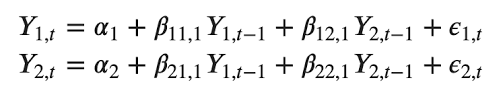

In [2]:
filepath = r"/home/marko/Documents/ElectionLogic/src/2024-polls/2024-1010.csv"
macro_data = pd.read_csv(filepath)
print(macro_data.shape)  # (123, 8)
macro_data['HDZ'] = macro_data['HDZ'].astype(float)
macro_data.head()

(1010, 10)


,KH,DPMS,Centar,SDP,HNS,Fokus,HDZ,Mozemo,Most,RF
0,2.34,8.11,1.55,17.83,1.41,1.35,33.99,15.03,7.56,1.35
1,2.25,8.13,1.53,17.85,1.40,1.37,33.96,15.11,7.54,1.34
2,2.16,8.14,1.51,17.86,1.39,1.40,33.94,15.20,7.52,1.33
3,2.07,8.16,1.50,17.88,1.38,1.43,33.92,15.29,7.51,1.32
4,1.98,8.17,1.48,17.90,1.37,1.45,33.89,15.37,7.49,1.31


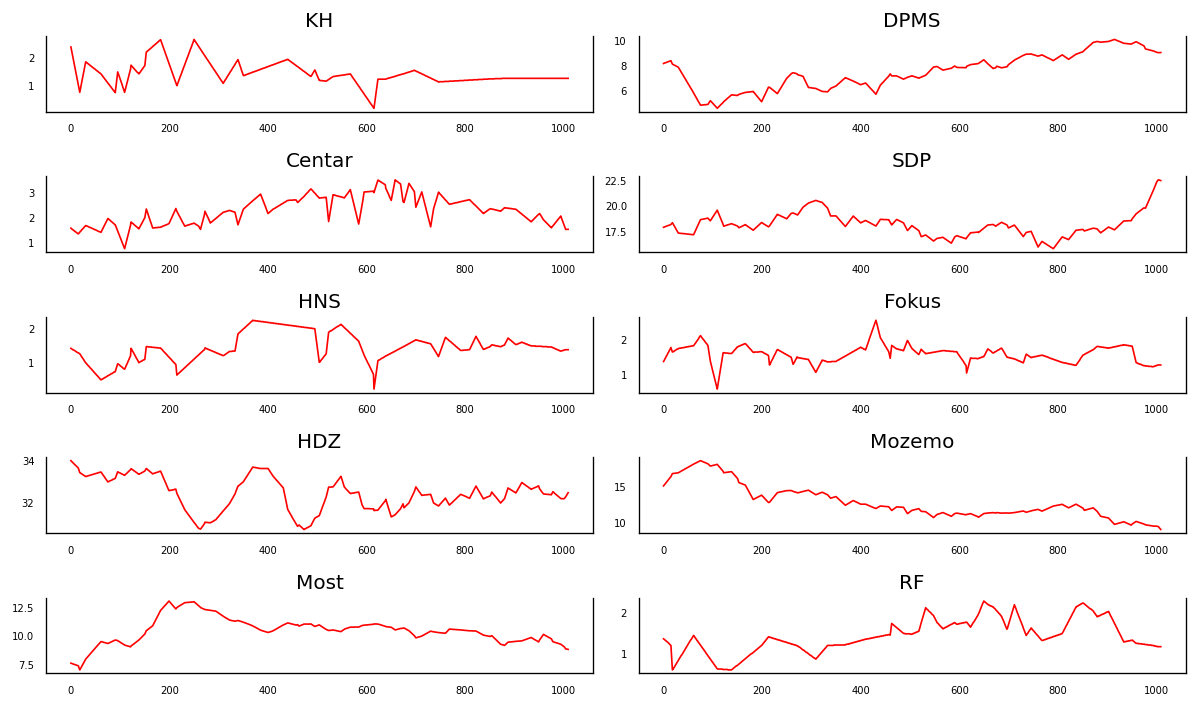

In [3]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(macro_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# DATA STATIONARITY CHECK:

In [4]:
col_names = macro_data.columns

for i in range (len(col_names)):
    ad_fuller_result = adfuller(macro_data[col_names[i]].diff()[1:])
    
    print(col_names[i])
    print(f'ADF Statistic: {ad_fuller_result[0]}')
    print(f'p-value: {ad_fuller_result[1]}')
    
    print('\n---------------------\n')

KH
ADF Statistic: -8.759572093453194
p-value: 2.697002667398345e-14

---------------------

DPMS
ADF Statistic: -7.058138269238745
p-value: 5.309066119505824e-10

---------------------

Centar
ADF Statistic: -10.385736444683879
p-value: 2.082444112085706e-18

---------------------

SDP
ADF Statistic: -8.548923827556104
p-value: 9.337543032324562e-14

---------------------

HNS
ADF Statistic: -10.525056941878209
p-value: 9.464516006035313e-19

---------------------

Fokus
ADF Statistic: -10.94960889328921
p-value: 8.866124112696421e-20

---------------------

HDZ
ADF Statistic: -7.794509055823943
p-value: 7.782207379389912e-12

---------------------

Mozemo
ADF Statistic: -8.067545102878208
p-value: 1.5813598826120607e-12

---------------------

Most
ADF Statistic: -7.397655252756826
p-value: 7.702061871434067e-11

---------------------

RF
ADF Statistic: -10.488099343037302
p-value: 1.1660675393027934e-18

---------------------



# DATA CAUSALITY CHECK:

In [5]:
col_names = macro_data.columns

for i in range(len(col_names)):
    for j in range(len(col_names)):
        if i == j: continue
        print(col_names[i] + ' causes ' + col_names[j])
        print('------------------')
        granger_1 = grangercausalitytests(macro_data[[col_names[j], col_names[i]]], 4)
        print('------------------')
        print('------------------')


KH causes DPMS
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2112  , p=0.0404  , df_denom=1006, df_num=1
ssr based chi2 test:   chi2=4.2238  , p=0.0399  , df=1
likelihood ratio test: chi2=4.2149  , p=0.0401  , df=1
parameter F test:         F=4.2112  , p=0.0404  , df_denom=1006, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5566  , p=0.5734  , df_denom=1003, df_num=2
ssr based chi2 test:   chi2=1.1187  , p=0.5716  , df=2
likelihood ratio test: chi2=1.1181  , p=0.5718  , df=2
parameter F test:         F=0.5566  , p=0.5734  , df_denom=1003, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7562  , p=0.5188  , df_denom=1000, df_num=3
ssr based chi2 test:   chi2=2.2845  , p=0.5155  , df=3
likelihood ratio test: chi2=2.2819  , p=0.5160  , df=3
parameter F test:         F=0.7562  , p=0.5188  , df_denom=1000, df_num=3

Granger Causality
number of lags (no zero) 4
ssr base

# SORTING DATA TO TRAINING AND TESTING:

In [6]:
#macro_data = macro_data.iloc[:200, :]
print(macro_data.shape)

(1010, 10)


In [30]:
train_df=macro_data[:-24]
test_df=macro_data[-24:]

In [31]:
print(test_df.shape)

(24, 10)


# FINDING APPROPRIATE LAG VARIABLE:

In [46]:
model = VAR(macro_data.diff()[1:])

In [47]:
sorted_order=model.select_order(maxlags=4)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -70.47      -70.42   2.493e-31      -70.45
1      -82.25     -81.71*   1.902e-36      -82.05
2     -82.44*      -81.42  1.570e-36*     -82.05*
3      -82.39      -80.87   1.654e-36      -81.81
4      -82.37      -80.36   1.691e-36      -81.61
-------------------------------------------------


# FITTING DATA INTO MODEL:

In [48]:
var_model = VARMAX(macro_data, order=(2,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                                         Statespace Model Results                                                         
Dep. Variable:     ['KH', 'DPMS', 'Centar', 'SDP', 'HNS', 'Fokus', 'HDZ', 'Mozemo', 'Most', 'RF']   No. Observations:                 1010
Model:                                                                                     VAR(2)   Log Likelihood               -4807.520
                                                                                      + intercept   AIC                          10145.041
Date:                                                                            Sun, 07 Apr 2024   BIC                          11448.233
Time:                                                                                    19:12:03   HQIC                         10640.105
Sample:                                                                                         0                                         
                           

# FORECASTING + VISUALISATION:

In [58]:
n_forecast = 24
predict = fitted_model.get_prediction(start=len(macro_data)-1,end=len(macro_data) + n_forecast-1)#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [59]:
predictions.columns=['kh_predicted', 'dpms_predicted', 'centar_predicted', 'sdp_predicted', 'hns_predicted', 'fokus_predicted', 'hdz_predicted','mozemo_predicted', 'most_predicted', 'rf_predicted']
predictions

,kh_predicted,dpms_predicted,centar_predicted,sdp_predicted,hns_predicted,fokus_predicted,hdz_predicted,mozemo_predicted,most_predicted,rf_predicted
1009,1.329865,8.858035,2.003038,19.968914,1.601564,1.304392,32.211419,9.661528,9.197296,1.418681
1010,1.328667,8.876204,2.006996,19.957029,1.605938,1.304371,32.220670,9.597899,9.191028,1.424456
1011,1.334580,8.858052,2.099700,19.509926,1.634052,1.331772,32.246813,9.788287,9.310721,1.473802
1012,1.344255,8.681670,2.209196,18.859273,1.641693,1.384853,32.347602,10.350852,9.537239,1.502612
1013,1.344679,8.588422,2.244222,18.620631,1.634418,1.408561,32.370298,10.607006,9.631892,1.508262
1014,1.347450,8.434666,2.264564,18.410538,1.614765,1.435079,32.410256,10.966297,9.739982,1.494468
1015,1.349479,8.331300,2.270668,18.310300,1.599419,1.450206,32.425880,11.191797,9.803383,1.482351
1016,1.352891,8.214593,2.269370,18.238762,1.581256,1.464209,32.445438,11.432950,9.863587,1.463303
1017,1.355856,8.126113,2.265619,18.200321,1.567149,1.473603,32.456419,11.609297,9.905485,1.447816
1018,1.359169,8.040459,2.259576,18.175558,1.553412,1.481745,32.467882,11.776261,9.942419,1.431177


In [60]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<Axes: >

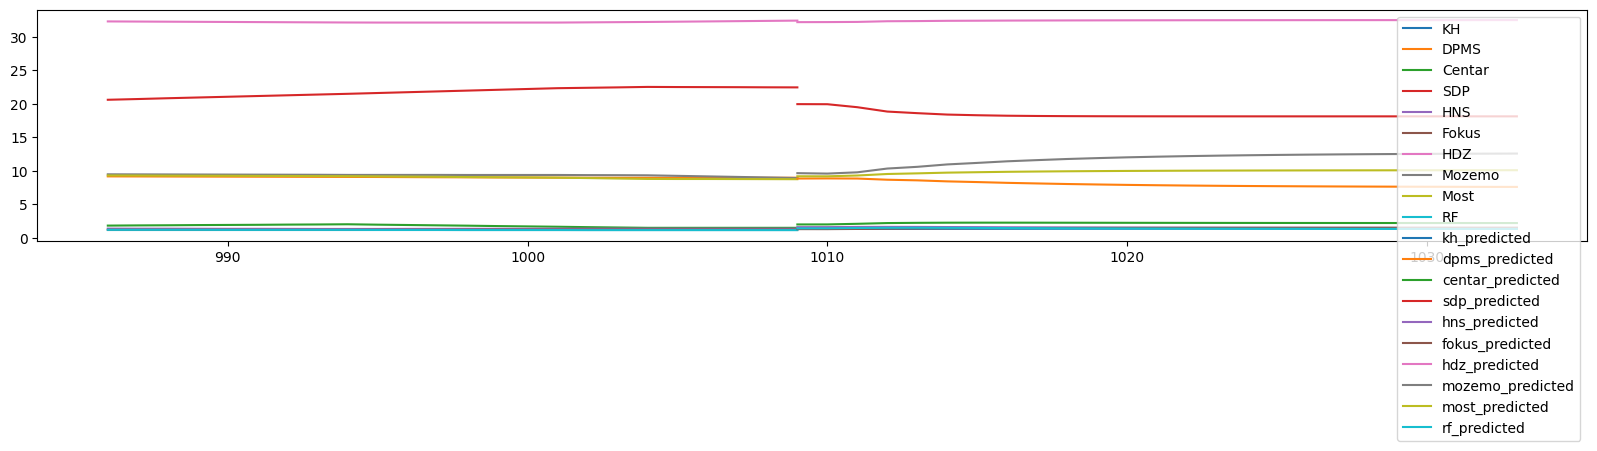

In [62]:
test_vs_pred.plot(figsize=(20,3))

# FORECASTING ERROR CHECK:

In [45]:
from sklearn.metrics import mean_absolute_error
import math 
from statistics import mean

rmse_kh=mean_absolute_error(predictions['kh_predicted'],test_df['KH'])
print('KH ERROR: '+ str(rmse_kh/mean(test_df['KH'])))

rmse_dpms=mean_absolute_error(predictions['dpms_predicted'],test_df['DPMS'])
print('DPMS ERROR: '+ str(rmse_dpms/mean(test_df['DPMS'])))

rmse_centar=mean_absolute_error(predictions['centar_predicted'],test_df['Centar'])
print('Centar ERROR: '+ str(rmse_centar/mean(test_df['Centar'])))

rmse_sdp=mean_absolute_error(predictions['sdp_predicted'],test_df['SDP'])
print('SDP ERROR: '+ str(rmse_sdp/mean(test_df['SDP'])))

rmse_hns=mean_absolute_error(predictions['hns_predicted'],test_df['HNS'])
print('HNS ERROR: '+ str(rmse_hns/mean(test_df['HNS'])))

rmse_fokus=mean_absolute_error(predictions['fokus_predicted'],test_df['Fokus'])
print('Fokus ERROR: '+ str(rmse_fokus/mean(test_df['Fokus'])))

rmse_hdz=mean_absolute_error(predictions['hdz_predicted'],test_df['HDZ'])
print('HDZ ERROR: '+ str(rmse_hdz/mean(test_df['HDZ'])))

rmse_mozemo=mean_absolute_error(predictions['mozemo_predicted'],test_df['Mozemo'])
print('Mozemo ERROR: '+ str(rmse_mozemo/mean(test_df['Mozemo'])))

rmse_most=mean_absolute_error(predictions['most_predicted'],test_df['Most'])
print('Most ERROR: '+ str(rmse_most/mean(test_df['Most'])))

rmse_rf=mean_absolute_error(predictions['rf_predicted'],test_df['RF'])
print('RF ERROR: '+ str(rmse_rf/mean(test_df['RF'])))

KH ERROR: 0.07786365173156691
DPMS ERROR: 0.004699149081105919
Centar ERROR: 0.0879604712486348
SDP ERROR: 0.044798665458456476
HNS ERROR: 0.09652310133170801
Fokus ERROR: 0.06546558254699168
HDZ ERROR: 0.007855349196342981
Mozemo ERROR: 0.007399916048430071
Most ERROR: 0.008421485825722642
RF ERROR: 0.022769457266474058
